<img src="./images/arm_logo.png" width=500 alt="ARM Logo"></img>

# ACT Basics
---

## Overview
Welcome to the ARM/ASR Open Science Workshop Tutorial on the **Atmospheric data Community Toolkit (ACT)**
In this tutorial, you will learn some of the basic features of ACT with a focus on how you can use it to better utilize ARM's data quality information.  This will include using ARM's embedded quality control information that's included in many ARM NetCDF files and Data Quality Reports (DQR) which can be accessed through a webservice.

ACT is built around the xarray data object, which you can learn about more in the xarray tutorial on Friday at 3 pm Eastern or through information from __[Project Pythia](https://foundations.projectpythia.org/core/xarray.html)__. 

## Installation

If you don't have ACT already installed, it can be installed using pip or conda using the commands below.  Additional information on installation can be found in the __[ACT User Guide](https://arm-doe.github.io/ACT/userguide/index.html)__. 

`pip install act-atmos`

`conda install -c conda-forge act-atmos`

Some features of ACT are only available if you have some optional dependencies installed.  For example, Skew-T plots of radiosonde data will require that __[MetPy](https://unidata.github.io/MetPy/latest/index.html)__ is installed.  Additional optional dependencies are listed in __[ACT's documentation](https://arm-doe.github.io/ACT/index.html)__

## Imports
First we are going to start by importing all the necessary python libraries that we need which is just act and matplotlib.

In [4]:
import act
import matplotlib.pyplot as plt

## Download ARM Data
Next we are going to download the data we are going to use for this session using the __[ARM Live Data webservice](https://adc.arm.gov/armlive/)__.  

Since you have an ARM user account, you should be able to utilize this webservice as well.  All you need to do is login to get your token.  In case you are not able to get that information, we have a username and token set up just for training sessions.

In [5]:
# Set your own username and token if you have it
username = 'armlive_training'
token = '5ab7d814ae1297c5'

# ACT module for downloading data from the ARM web service
results = act.discovery.download_data(username, token, 'sgpmfrsr7nchE11.b1', '2021-03-29', '2021-03-29')
print(results)

[DOWNLOADING] sgpmfrsr7nchE11.b1.20210329.070000.nc
['/Users/atheisen/Code/ARM-Notebooks/Open-Science-Workshop-2022/tutorials/sgpmfrsr7nchE11.b1/sgpmfrsr7nchE11.b1.20210329.070000.nc']


## Reading in a NetCDF File
Congratulations, you just downloaded a file from just the command line!  Next up is to read the file into an xarray object using the ACT reader.  We then can use Jupyter to print out an interactive listing of everything in the object.

In [6]:
obj = act.io.armfiles.read_netcdf(results)
obj

<xarray.Dataset>
Dimensions:                                  (time: 4320, bench_angle: 181, wavelength: 750)
Coordinates:
  * time                                     (time) datetime64[ns] 2021-03-29...
  * bench_angle                              (bench_angle) float32 0.0 ... 180.0
Dimensions without coordinates: wavelength
Data variables: (12/158)
    base_time                                datetime64[ns] 2021-03-29
    time_offset                              (time) datetime64[ns] 2021-03-29...
    hemisp_narrowband_filter1                (time) float32 dask.array<chunksize=(4320,), meta=np.ndarray>
    qc_hemisp_narrowband_filter1             (time) int32 dask.array<chunksize=(4320,), meta=np.ndarray>
    hemisp_narrowband_filter2                (time) float32 dask.array<chunksize=(4320,), meta=np.ndarray>
    qc_hemisp_narrowband_filter2             (time) int32 dask.array<chunksize=(4320,), meta=np.ndarray>
    ...                                       ...
    nominal_calibration_factor_filter5       float32 ...
    nominal_calibration_factor_filter6       float32 ...
    nominal_calibration_factor_filter7       float32 ...
    lat                                      float32 ...
    lon                                      float32 ...
    alt                                      float32 ...
Attributes: (12/38)
    command_line:                mfrsr7nch_ingest -s sgp -f E11
    Conventions:                 ARM-1.2
    process_version:             ingest-mfrsr7nch-1.3-0.el7
    dod_version:                 mfrsr7nch-b1-1.1
    input_source:                /data/collection/sgp/sgpmfrsr7nchE11.00/MFRS...
    site_id:                     sgp
    ...                          ...
    doi:                         10.5439/1429369
    history:                     created by user dsmgr on machine flint at 20...
    _file_dates:                 ['20210329']
    _file_times:                 ['070000']
    _datastream:                 sgpmfrsr7nchE11.b1
    _arm_standards_flag:         1

## Clean up the object to CF Standards
In order to utilize all the ACT QC modules, we need to clean up the object to follow __[Climate and Forecast (CF) standards](https://cfconventions.org/)__.  

In [8]:
obj.clean.cleanup()
obj

<xarray.Dataset>
Dimensions:                                  (time: 4320, bench_angle: 181, wavelength: 750)
Coordinates:
  * time                                     (time) datetime64[ns] 2021-03-29...
  * bench_angle                              (bench_angle) float32 0.0 ... 180.0
Dimensions without coordinates: wavelength
Data variables: (12/158)
    base_time                                datetime64[ns] 2021-03-29
    time_offset                              (time) datetime64[ns] 2021-03-29...
    hemisp_narrowband_filter1                (time) float32 dask.array<chunksize=(4320,), meta=np.ndarray>
    qc_hemisp_narrowband_filter1             (time) int32 dask.array<chunksize=(4320,), meta=np.ndarray>
    hemisp_narrowband_filter2                (time) float32 dask.array<chunksize=(4320,), meta=np.ndarray>
    qc_hemisp_narrowband_filter2             (time) int32 dask.array<chunksize=(4320,), meta=np.ndarray>
    ...                                       ...
    nominal_calibration_factor_filter5       float32 ...
    nominal_calibration_factor_filter6       float32 ...
    nominal_calibration_factor_filter7       float32 ...
    lat                                      float32 ...
    lon                                      float32 ...
    alt                                      float32 ...
Attributes: (12/31)
    command_line:                mfrsr7nch_ingest -s sgp -f E11
    Conventions:                 ARM-1.2
    process_version:             ingest-mfrsr7nch-1.3-0.el7
    dod_version:                 mfrsr7nch-b1-1.1
    input_source:                /data/collection/sgp/sgpmfrsr7nchE11.00/MFRS...
    site_id:                     sgp
    ...                          ...
    doi:                         10.5439/1429369
    history:                     created by user dsmgr on machine flint at 20...
    _file_dates:                 ['20210329']
    _file_times:                 ['070000']
    _datastream:                 sgpmfrsr7nchE11.b1
    _arm_standards_flag:         1

### First Visualization
Let's plot up some data to see what we're working with.  For this example, we'll use diffuse_hemisp_narrowband_filter4

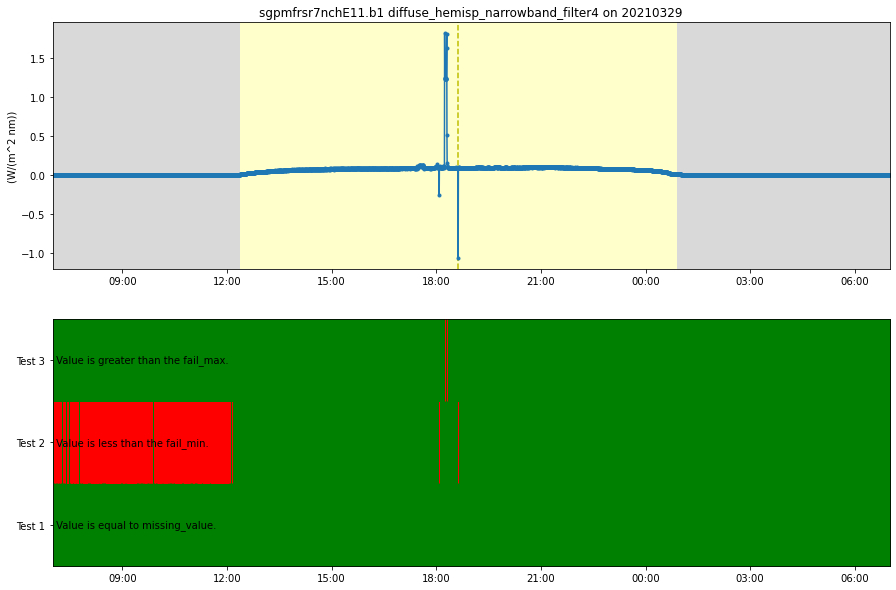

In [13]:
variable = 'diffuse_hemisp_narrowband_filter4'

# Create a plotting display object with 2 plots
display = act.plotting.TimeSeriesDisplay(obj, figsize=(15, 10), subplot_shape=(2,))

# Plot up the diffuse variable in the first plot
display.plot(variable, subplot_index=(0,))

# Plot up a day/night background
display.day_night_background(subplot_index=(0,))

# Plot up the QC variable in the second plot
display.qc_flag_block_plot(variable, subplot_index=(1,))

plt.show()

## Filter Data

Let's try and filter some of those outliers out based on the embedded QC in the files.

<AxesSubplot:>

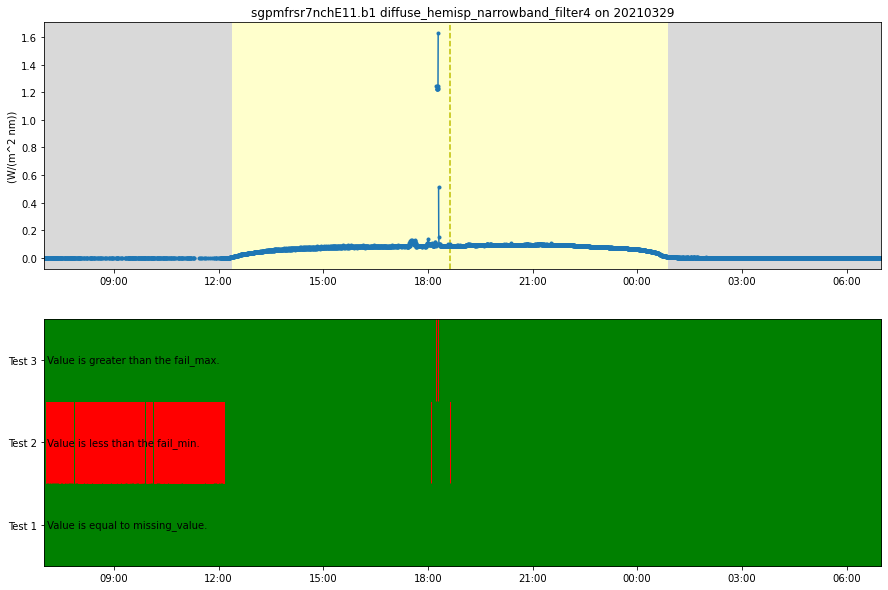

In [14]:
# Now lets remove some of these outliers
obj.qcfilter.datafilter(variable, rm_tests=[2, 3], del_qc_var=False)

# And plot the data again
# Create a plotting display object with 2 plots
display = act.plotting.TimeSeriesDisplay(obj, figsize=(15, 10), subplot_shape=(2,))

# Plot up the diffuse variable in the first plot
display.plot(variable, subplot_index=(0,))

# Plot up a day/night background
display.day_night_background(subplot_index=(0,))

# Plot up the QC variable in the second plot
display.qc_flag_block_plot(variable, subplot_index=(1,))

plt.show()

## Query the DQR Webservice
Since the embedded QC is not removing all the outliers, let's check to see if there are any Data Quality Reports (DQR) using ARMs DQR Webservice.  The great thing is, that ACT has codes for working with this webservice.

In this example, we can see that there's a DQRfor a shadowband misalignment and we can find out more information by looking at the actual __[DQR](https://adc.arm.gov/ArchiveServices/DQRService?dqrid=D210405.5)__.

<AxesSubplot:>

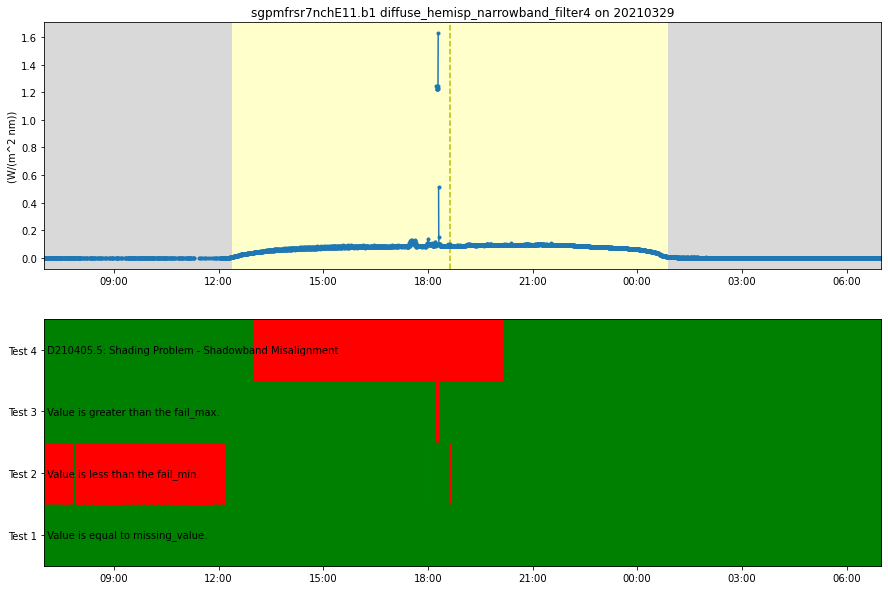

In [15]:
# Query the ARM DQR Webservice
obj = act.qc.arm.add_dqr_to_qc(obj, variable=variable)

#And plot again!
# Create a plotting display object with 2 plots
display = act.plotting.TimeSeriesDisplay(obj, figsize=(15, 10), subplot_shape=(2,))

# Plot up the diffuse variable in the first plot
display.plot(variable, subplot_index=(0,))

# Plot up a day/night background
display.day_night_background(subplot_index=(0,))

# Plot up the QC variable in the second plot
display.qc_flag_block_plot(variable, subplot_index=(1,))

plt.show()

## Add QC Tests
ACT has a number of additional __[QC tests](https://arm-doe.github.io/ACT/API/generated/act.qc.QCTests.html#act.qc.QCTests)__ that could be applied to the data.  For this next example, let's apply a new maximum test and bring that upper limit down a bit.  We are also going to filter the data based on this new test and plot up the results.

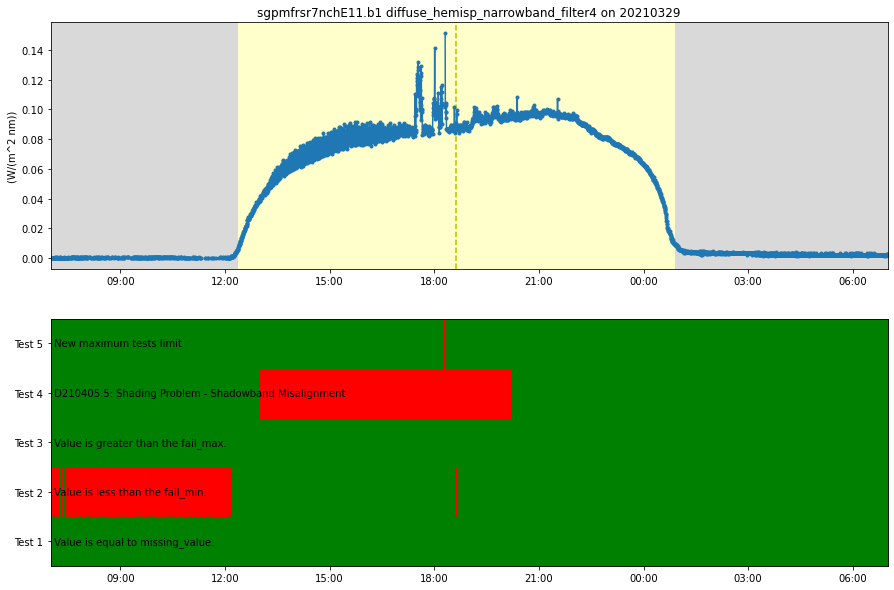

In [16]:
# Add a new maximum tests
obj.qcfilter.add_greater_test(variable, 0.4, test_meaning='New maximum tests limit')

# Filter that test out
obj.qcfilter.datafilter(variable, rm_tests=[5], del_qc_var=False)

#And plot again!
# Create a plotting display object with 2 plots
display = act.plotting.TimeSeriesDisplay(obj, figsize=(15, 10), subplot_shape=(2,))

# Plot up the diffuse variable in the first plot
display.plot(variable, subplot_index=(0,))

# Plot up a day/night background
display.day_night_background(subplot_index=(0,))

# Plot up the QC variable in the second plot
display.qc_flag_block_plot(variable, subplot_index=(1,))

plt.show()

## Instrument Specific QC Tests
ACT has a growing library of instrument specific tests such as the __[fast-fourier transform test](https://arm-doe.github.io/ACT/API/generated/act.qc.fft_shading_test.html#act.qc.fft_shading_test)__ to detect shading which was adapted from Alexandrov et al 2007.  The adaption is that it is applied in a moving window style approach.  **Note - Check out the webpage as an example of how we are including references to papers behind the codes**

Let's apply it and see how it compares with the DQR!

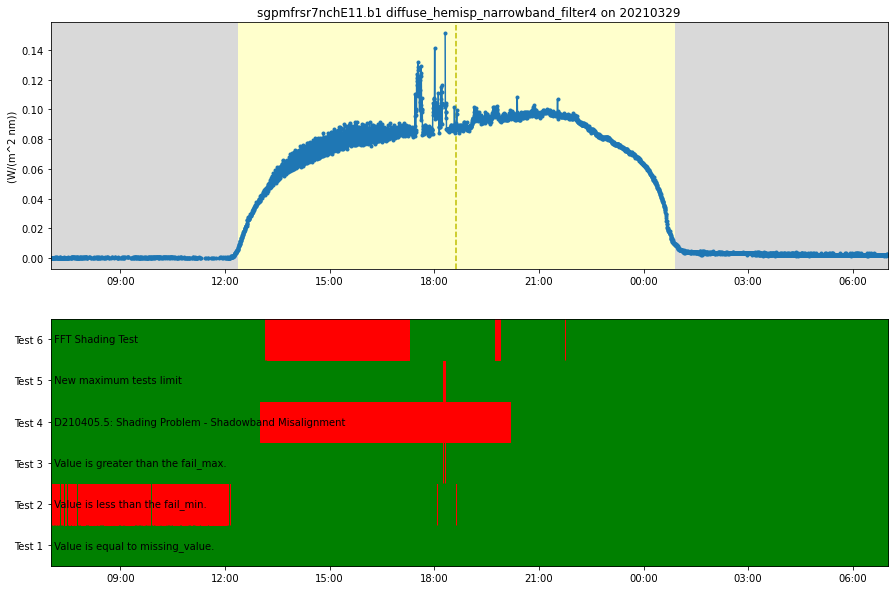

In [17]:
# Apply test
obj = act.qc.fft_shading_test(obj, variable=variable)

# Create a plotting display object with 2 plots
display = act.plotting.TimeSeriesDisplay(obj, figsize=(15, 10), subplot_shape=(2,))

# Plot up the diffuse variable in the first plot
display.plot(variable, subplot_index=(0,))

# Plot up a day/night background
display.day_night_background(subplot_index=(0,))

# Plot up the QC variable in the second plot
display.qc_flag_block_plot(variable, subplot_index=(1,))

plt.show()

## Conclusion
In this tutorial, we have shown you how to download data from ARM's Data Live web service, visualize the data and QC information, query the DQR webservice, filter data based on the QC, and add new QC tests to the dataset.  After all this work, you can easily save the xarray object to a NetCDF file using `obj.to_netcdf('filename.nc')` and all that data will be saved and usable in Python and ACT.

Please checkout the __[ACT Github repository](https://github.com/ARM-DOE/ACT)__ for the latest and greatest information, including our documentation which has __[examples](https://arm-doe.github.io/ACT/source/auto_examples/index.html)__ that can be downloading in python or Jupyter Notebook formats.

# Second ACT!

But wait, there's more to ACT that we can explore together or that you can do on your own!  These examples are going to be more condensed than the above but should still provide you the insight you need to run and do your own things!

We are going to need some additional libraries to help out though!

## Imports

In [18]:
import numpy as np

## Wind Roses

[DOWNLOADING] sgpmetE13.b1.20210524.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210526.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210527.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210528.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210529.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210530.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210521.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210523.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210514.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210516.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210519.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210513.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210512.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210520.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210517.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210515.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210511.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210518.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210522.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210525.000000.cdf
[DOWNLOADING] sgpmetE13.b1.20210531.000000.cdf
[DOWNLOADING]

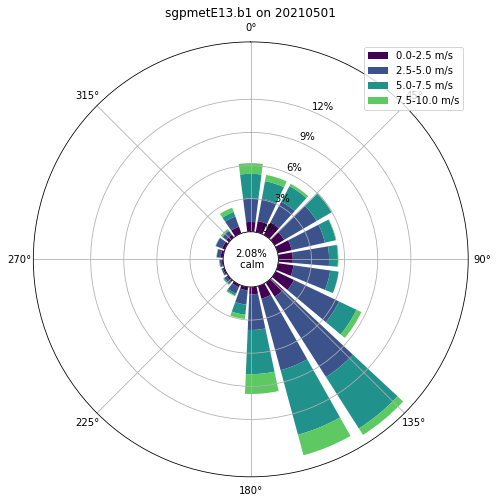

In [19]:
# Let's download a month of surface meteorological data from the SGP central facility!
results = act.discovery.download_data(username, token, 'sgpmetE13.b1', '2021-05-01', '2021-05-31')

# Read that data into an object (this will concatenate it all for you)
obj = act.io.armfiles.read_netcdf(results)

# Now we can plot up a wind rose of that entire month's worth of data
windrose = act.plotting.WindRoseDisplay(obj, figsize=(10,8))
windrose.plot('wdir_vec_mean', 'wspd_vec_mean', spd_bins=np.linspace(0, 10, 5))
windrose.axes[0].legend()
plt.show()

## Present Weather Detector Codes
With the MET system at the main site, there's also a present weather detector (PWD) deployed.  This PWD reports the present weather in WMO codes but can be easily decoded using a __[utility in ACT](https://arm-doe.github.io/ACT/API/generated/act.utils.decode_present_weather.html?highlight=present%20weather#act.utils.decode_present_weather)__.  With this information, you can make fancy plots like the __[DQ Office plots for the PWD](https://plot.dmf.arm.gov/PLOTS/sgp/sgpmet/20210522/sgpmetE13.b1.pwd_weather.20210522.png)__.

In [29]:
# Let's just use one of the files from the previous example
obj = act.io.armfiles.read_netcdf(results[21])

# Pass it to the function to decode it along with the variable name
obj = act.utils.inst_utils.decode_present_weather(obj, variable='pwd_pw_code_inst')

# We're going to print out the first 10 decoded values that weren't 0
# This shows the utility of also being able to use the built-in xarray
# features like where!
print(list(obj['pwd_pw_code_inst_decoded'].where(obj.pwd_pw_code_inst > 0, drop=True).values[0:10]))

/Users/atheisen/Code/ARM-Notebooks/Open-Science-Workshop-2022/tutorials/sgpmetE13.b1/sgpmetE13.b1.20210522.000000.cdf
['Rain, not freezing, slight', 'Rain, not freezing, slight', 'Drizzle, not freezing, slight', 'Drizzle, not freezing, slight', 'Drizzle, not freezing, slight', 'Drizzle, not freezing, slight', 'Drizzle, not freezing, slight', 'Drizzle, not freezing, slight', 'Drizzle, not freezing, slight', 'Drizzle, not freezing, slight']


## Doppler Lidar Wind Retrievals
This will show you how you can process the doppler lidar PPI scans to produce __[wind profiles](https://arm-doe.github.io/ACT/API/generated/act.retrievals.compute_winds_from_ppi.html#act.retrievals.compute_winds_from_ppi)__ based on Newsom et al 2016.   

/Users/atheisen/Code/ACT/act/plotting/plot.py:80: UserWarning: Could not discern datastreamname and dict or tuple were not provided. Using defaultname of act_datastream!
  warnings.warn(


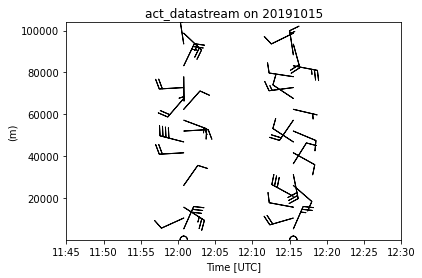

In [56]:
# We're going to use some test data that already exists within ACT
obj = act.io.armfiles.read_netcdf(act.tests.sample_files.EXAMPLE_DLPPI_MULTI)

# Returns the wind retrieval information in a new object by default
# Note that the default snr_threshold of 0.008 was too high for the first profile
# Reducing it to 0.002 makes it show up but the quality of the data is likely suspect.
wind_obj = act.retrievals.compute_winds_from_ppi(obj, snr_threshold=0.002)

# Plot it up
display = act.plotting.TimeSeriesDisplay(wind_obj)
display.plot_barbs_from_spd_dir('wind_direction', 'wind_speed', invert_y_axis=False)

#Update the x-limits to make sure both wind profiles are shown
#display.axes[0].set_xlim([np.datetime64('2019-10-15T11:45'), np.datetime64('2019-10-15T12:30')])

plt.show()

## Radiosonde Plotting and More!

This will take you through how to plot up a Skew-T plot along with a geographic plot of the radiosonde track on a map.  Additionally, will run this through a retrieval to calculate the PBL height using the __[Liu Liang method](https://arm-doe.github.io/ACT/API/generated/act.retrievals.calculate_pbl_liu_liang.html?highlight=pbl#act.retrievals.calculate_pbl_liu_liang)__.

/Users/atheisen/Code/ACT/act/plotting/plot.py:80: UserWarning: Could not discern datastreamname and dict or tuple were not provided. Using defaultname of act_datastream!
  warnings.warn(


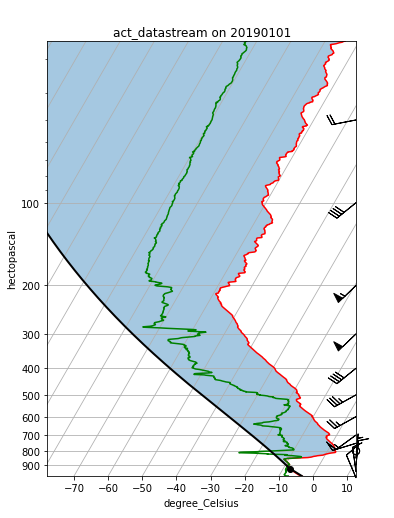

In [74]:
# Import MetPy if possible
import metpy

# Read in sample radiosonde data and plot up a Skew-T
obj = act.io.armfiles.read_netcdf(act.tests.EXAMPLE_SONDE1)

skewt = act.plotting.SkewTDisplay(obj, figsize=(10, 8))
skewt.plot_from_u_and_v('u_wind', 'v_wind', 'pres', 'tdry', 'dp')

plt.show()

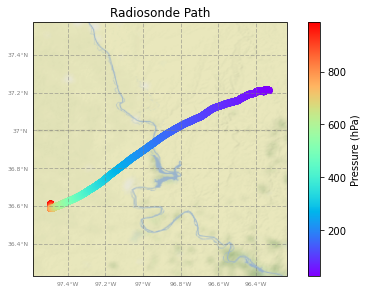

In [67]:
# Now let's plot up the radiosonde path on a map!
display = act.plotting.GeographicPlotDisplay(obj)
display.geoplot(data_field='pres', title='Radiosonde Path')
plt.show()

In [75]:
# We need to update the units on temperature before running the retrieval
obj['tdry'].attrs['units'] = 'degree_Celsius'
obj = act.retrievals.calculate_pbl_liu_liang(obj)
print('Regime = ', obj['pblht_regime_liu_liang'].values, '\nPBL Height = ', int(obj['pblht_liu_liang'].values))

Regime =  NRL 
PBL Height =  950


## Mimic ARM Data Files

ARM's NetCDF files are based around what we call a data object definition or DOD.  These DOD's essentially create the structure of the file and are what you see in the NetCDF file as the header.  We can use this information to create an  xarray object, filled with missing value, that one can populated with data and then write it out to a NetCDF file that looks exactly like an ARM file.

The user is able to set up the size of the datasets ahead of time by passing in the dimension sizes as shown below with `{'time': 1440}`

This could greatly streamline and improve the usability of PI-submitted datasets.  

**Note, that this does take some time for datastreams like the MET that have a lot of versions.**

In [81]:
obj = act.io.armfiles.create_obj_from_arm_dod('met.b1', {'time': 1440}, scalar_fill_dim='time')

# Create some random data and set it to the variable in the obect like normal
obj['temp_mean'].values = np.random.rand(1440)
obj

/Users/atheisen/Code/ACT/act/io/armfiles.py:321: UserWarning: Version:  not available or not specified. Using Version: 9.4
  warnings.warn(


<xarray.Dataset>
Dimensions:                       (time: 1440)
Coordinates:
  * time                          (time) int64 0 1 2 3 4 ... 1436 1437 1438 1439
Data variables: (12/44)
    base_time                     (time) float64 -9.999e+03 ... -9.999e+03
    time_offset                   (time) float64 -9.999e+03 ... -9.999e+03
    atmos_pressure                (time) float64 -9.999e+03 ... -9.999e+03
    qc_atmos_pressure             (time) float64 -9.999e+03 ... -9.999e+03
    temp_mean                     (time) float64 0.6109 0.5403 ... 0.7006
    qc_temp_mean                  (time) float64 -9.999e+03 ... -9.999e+03
    ...                            ...
    qc_logger_volt                (time) float64 -9.999e+03 ... -9.999e+03
    logger_temp                   (time) float64 -9.999e+03 ... -9.999e+03
    qc_logger_temp                (time) float64 -9.999e+03 ... -9.999e+03
    lat                           (time) float64 -9.999e+03 ... -9.999e+03
    lon                           (time) float64 -9.999e+03 ... -9.999e+03
    alt                           (time) float64 -9.999e+03 ... -9.999e+03
Attributes: (12/27)
    command_line:                
    process_version:             
    dod_version:                 
    input_source:                
    site_id:                     
    platform_id:                 
    ...                          ...
    qc_bit_2_assessment:         Bad
    qc_bit_3_description:        Value is greater than the valid_max.
    qc_bit_3_assessment:         Bad
    qc_bit_4_description:        Difference between current and previous valu...
    qc_bit_4_assessment:         Indeterminate
    history: